
# Facies classification using machine learning techniques
The ideas of 
<a href="https://home.deib.polimi.it/bestagini/">Paolo Bestagini's</a> "Try 2", <a href="https://github.com/ar4">Alan Richardson's</a> "Try 2",
<a href="https://github.com/dalide">Dalide's</a> "Try 6", augmented, by Dimitrios Oikonomou and Eirik Larsen (ESA AS) by 

- adding the gradient of gradient of features as augmented features.
- with an ML estimator for PE using both training and blind well data.
- removing the NM_M from augmented features. 
 
In the following, we provide a possible solution to the facies classification problem described at https://github.com/seg/2016-ml-contest.

The proposed algorithm is based on the use of random forests, xgboost or gradient boost combined in one-vs-one multiclass strategy. In particular, we would like to study the effect of:
- Robust feature normalization.
- Feature imputation for missing feature values.
- Well-based cross-validation routines.
- Feature augmentation strategies.
- Test multiple classifiers 


# Script initialization
Let's import the used packages and define some parameters (e.g., colors, labels, etc.).

In [1]:
# Import
from __future__ import division
get_ipython().magic(u'matplotlib inline')
import matplotlib as mpl

import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20.0, 10.0)
inline_rc = dict(mpl.rcParams)
from classification_utilities import make_facies_log_plot

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from scipy.signal import medfilt

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import sys, scipy, sklearn
print('Python:  ' + sys.version.split('\n')[0])
print('         ' + sys.version.split('\n')[0])
print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Scipy:   ' + scipy.__version__)
print('Sklearn: ' + sklearn.__version__)
print('Xgboost: ' + xgb.__version__)

Python:  2.7.12 (default, Nov 19 2016, 06:48:10) 
         2.7.12 (default, Nov 19 2016, 06:48:10) 
Pandas:  0.19.2
Numpy:   1.12.0
Scipy:   0.18.1
Sklearn: 0.18.1
Xgboost: 0.6


### Parameters

In [3]:
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

#Select classifier type

#clfType='RF'  #Random Forest clasifier
#clfType='GB'  #Gradient Boosting Classifier
#clfType='XB'  #XGB Clasifier
clfType='XBA'  #XGB Clasifier

#Seed
seed = 24
np.random.seed(seed)

# Load data
Let's load the data

In [4]:
# Load data from file
data = pd.read_csv('../facies_vectors.csv')

# Load Test data from file
test_data = pd.read_csv('../validation_data_nofacies.csv') 
test_data.insert(0,'Facies',np.ones(test_data.shape[0])*(-1))

#Create Dataset for PE prediction from both dasets
all_data=pd.concat([data,test_data])

#### Let's store features, labels and other data into numpy arrays.


In [5]:
# Store features and labels
X = data[feature_names].values  # features

y = data['Facies'].values  # labels

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values


# Data inspection
Let us inspect the features we are working with. This step is useful to understand how to normalize them and how to devise a correct cross-validation strategy. Specifically, it is possible to observe that:
 - Some features seem to be affected by a few outlier measurements.
 - Only a few wells contain samples from all classes.
 - PE measurements are available only for some wells.

In [6]:
# Define function for plotting feature statistics
def plot_feature_stats(X, y, feature_names, facies_colors, facies_names):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_names):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_names):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_names)))

## Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_names)
mpl.rcParams.update(inline_rc)


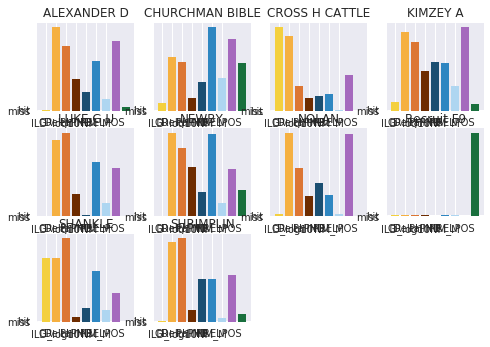

In [7]:
# Facies per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(y[well == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

 
# Features per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.logical_not(np.any(np.isnan(X[well == w, :]), axis=0))
    plt.bar(np.arange(len(hist)), hist, color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(feature_names)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['miss', 'hit'])
    ax.set_title(w)


## Feature imputation
Let us fill missing PE values. Currently no feature engineering is used, but this should be explored in the future.

In [8]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=seed)

DataImpAll = all_data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(data.PE.isnull()),feature_names.index('PE')] = reg.predict(data.loc[data.PE.isnull(),:][['GR', 'ILD_log10', 'DeltaPHI', 'PHIND',  'NM_M', 'RELPOS']])


# Augment features

In [9]:
# ## Feature augmentation
# Our guess is that facies do not abrutly change from a given depth layer to the next one. Therefore, we consider features at neighboring layers to be somehow correlated. To possibly exploit this fact, let us perform feature augmentation by:
# - Select features to augment.
# - Aggregating aug_features at neighboring depths.
# - Computing aug_features spatial gradient.
# - Computing aug_features spatial gradient of gradient.

In [10]:

# Feature windows concatenation function
def augment_features_window(X, N_neig, features=-1):
    
    # Parameters
    N_row = X.shape[0]
    if features==-1:
        N_feat = X.shape[1]
        features=np.arange(0,X.shape[1])
    else:
        N_feat = len(features)

    # Zero padding
    X = np.vstack((np.zeros((N_neig, X.shape[1])), X, (np.zeros((N_neig, X.shape[1])))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig)+X.shape[1]))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            if (c==0):
                this_row = np.hstack((this_row, X[r+c,:]))
            else:
                this_row = np.hstack((this_row, X[r+c,features]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth, features=-1):
    
    if features==-1:
        features=np.arange(0,X.shape[1])
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X[:,features], axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad



In [11]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1, features=-1):
    
    if (features==-1):
        N_Feat=X.shape[1]
    else:
        N_Feat=len(features)
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1] + N_Feat*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig,features)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx],features)
        X_aug_grad_grad = augment_features_gradient(X_aug_grad, depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad,X_aug_grad_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows


In [12]:
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v, well_v, clf):
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    # Train classifier
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=3)
  
    return y_v_hat

In [13]:
# Define window length
N_neig=1

# Define which features to augment by introducing window and gradients.
augm_Features=['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'RELPOS']

# Get the columns of features to be augmented 
feature_indices=[feature_names.index(log) for log in augm_Features]

# Augment features
X_aug, padded_rows = augment_features(X, well, depth, N_neig=N_neig, features=feature_indices)

# Remove padded rows 
data_no_pad = np.setdiff1d(np.arange(0,X_aug.shape[0]), padded_rows)

X=X[data_no_pad ,:]
depth=depth[data_no_pad]
X_aug=X_aug[data_no_pad ,:]
y=y[data_no_pad]
data=data.iloc[data_no_pad ,:]
well=well[data_no_pad]


## Generate training, validation and test data splitsar4_submission_withFac.ipynb
The choice of training and validation data is paramount in order to avoid overfitting and find a solution that generalizes well on new data. For this reason, we generate a set of training-validation splits so that:
- Features from each well belongs to training or validation set.
- Training and validation sets contain at least one sample for each class.

# Initialize model selection methods

In [14]:
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (data.iloc[split['train']]['Well Name'].unique()))
    print('    validation: %s' % (data.iloc[split['val']]['Well Name'].unique()))

Split 0
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['ALEXANDER D' 'CHURCHMAN BIBLE']
Split 1
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN' 'Recruit F9' 'NEWBY'
 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'CROSS H CATTLE']
Split 2
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'KIMZEY A']
Split 3
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'NOLAN']
Split 4
    training:   ['SHRIMPLIN' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'SHANKLE']
Split 5
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE' 'CHURCHMAN BIBLE'

## Classification parameters optimization
Let us perform the following steps for each set of parameters:

- Select a data split.
- Normalize features using a robust scaler.
- Train the classifier on training data.
- Test the trained classifier on validation data.
- Repeat for all splits and average the F1 scores. 
At the end of the loop, we select the classifier that maximizes the average F1 score on the validation set. Hopefully, this classifier should be able to generalize well on new data.

In [15]:

if clfType=='XB':
    md_grid = [3]
    mcw_grid = [1]
    gamma_grid = [0.3]  
    ss_grid = [0.7] 
    csb_grid = [0.8]
    alpha_grid =[0.2]
    lr_grid = [0.05]
    ne_grid = [200]
    param_grid = []
    for N in md_grid:
        for M in mcw_grid:
            for S in gamma_grid:
                for L in ss_grid:
                    for K in csb_grid:
                        for P in alpha_grid:
                            for R in lr_grid:
                                for E in ne_grid:
                                    param_grid.append({'maxdepth':N, 
                                                       'minchildweight':M, 
                                                       'gamma':S, 
                                                       'subsample':L,
                                                       'colsamplebytree':K,
                                                       'alpha':P,
                                                       'learningrate':R,
                                                       'n_estimators':E})
                                    
if clfType=='XBA':
    
    learning_rate=0.1
    max_depth=3
    min_child_weight=12
    colsample_bytree = 0.7
    n_estimators=150
    
    param_grid = []
    param_grid.append({'maxdepth':max_depth, 
                       'minchildweight':min_child_weight, 
                       'colsamplebytree':colsample_bytree,
                       'learningrate':learning_rate,
                       'n_estimators':n_estimators})

if clfType=='RF':
    N_grid = [100]  # [50, 100, 150]
    M_grid = [10]  # [5, 10, 15]
    S_grid = [25]  # [10, 25, 50, 75]
    L_grid = [5] # [2, 3, 4, 5, 10, 25]
    param_grid = []
    for N in N_grid:
        for M in M_grid:
            for S in S_grid:
                for L in L_grid:
                    param_grid.append({'N':N, 'M':M, 'S':S, 'L':L})
                    
if clfType=='GB':
    N_grid = [100]  
    MD_grid = [3]  
    M_grid = [10]
    LR_grid = [0.1]  
    L_grid = [5]
    S_grid = [25]  
    param_grid = []
    for N in N_grid:
        for M in MD_grid:
            for M1 in M_grid:
                for S in LR_grid: 
                    for L in L_grid:
                        for S1 in S_grid:
                            param_grid.append({'N':N, 'MD':M, 'MF':M1,'LR':S,'L':L,'S1':S1})



In [ ]:
def getClf(clfType, param):
    if clfType=='RF':
         clf = OneVsOneClassifier(RandomForestClassifier(n_estimators=param['N'], criterion='entropy',
                             max_features=param['M'], min_samples_split=param['S'], min_samples_leaf=param['L'],
                             class_weight='balanced', random_state=seed), n_jobs=-1)
    if clfType=='XB':
            clf = OneVsOneClassifier(XGBClassifier(
                learning_rate = param['learningrate'],
                n_estimators=param['n_estimators'],
                max_depth=param['maxdepth'],
                min_child_weight=param['minchildweight'],
                gamma = param['gamma'],
                subsample=param['subsample'],
                colsample_bytree=param['colsamplebytree'],
                reg_alpha = param['alpha'],
                nthread =4,
                seed = seed,
            ) , n_jobs=-1)

            
       
    if clfType=='XBA':
            clf = XGBClassifier(
                learning_rate = param['learningrate'],
                n_estimators=param['n_estimators'],
                max_depth=param['maxdepth'],
                min_child_weight=param['minchildweight'],
                colsample_bytree=param['colsamplebytree'],
                nthread =4,
                seed = 17
            )             
    if clfType=='GB':
        clf=OneVsOneClassifier(GradientBoostingClassifier(
                loss='exponential',
                n_estimators=param['N'], 
                learning_rate=param['LR'], 
                max_depth=param['MD'],
                max_features= param['MF'],
                min_samples_leaf=param['L'],
                min_samples_split=param['S1'],
                random_state=seed, 
                max_leaf_nodes=None,)
                               , n_jobs=-1)
    return clf

In [ ]:
# For each set of parameters
score_param = []
for param in param_grid:
    print('features: %d' % X_aug.shape[1])
    # For each data split
    score_split = []
    for split in split_list:
    
        split_train_no_pad = split['train']
        
        # Select training and validation data from current split
        X_tr = X_aug[split_train_no_pad, :]
        X_v = X_aug[split['val'], :]
        y_tr = y[split_train_no_pad]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v, getClf(clfType,param))
        
        # Score
        score = f1_score(y_v, y_v_hat, average='micro')
        score_split.append(score)
        #print('Split: {0}, Score = {1:0.3f}'.format(split_list.index(split),score))
    # Average score for this param
    score_param.append(np.mean(score_split))
    print('Average F1 score = %.3f %s' % (score_param[-1], param))

features: 31


In [ ]:
# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))

In [ ]:
# ## Predict labels on test data
# Let us now apply the selected classification technique to test data.

In [ ]:
# Training data
X_tr = X_aug
y_tr = y

# Prepare test data
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values

# Augment Test data features
X_ts, padded_rows = augment_features(X_ts, well_ts,depth_ts,N_neig=N_neig, features=feature_indices)

In [ ]:
# Predict test labels
y_ts_hat = train_and_test(X_tr, y_tr, X_ts, well_ts, getClf(clfType,param_best))

# Save predicted labels
test_data['Facies'] = y_ts_hat
test_data.to_csv('esa_predicted_facies_{0}_sub01.csv'.format(clfType))


In [ ]:
# Plot predicted labels
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
mpl.rcParams.update(inline_rc)
